In [1]:
# import pandas as pd
# import numpy as np 
# import pickle
# import xgboost as xgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# import mlflow
# import mlflow.sklearn

# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# from hyperopt.pyll import scope
# from sklearn import preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import datasets, linear_model
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error
# from sklearn import linear_model
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import mean_squared_error

import mlflow
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import json


In [2]:
import mlflow
from mlflow.exceptions import MlflowException

# Set tracking URI
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Get the experiment details
experiment_name = "boston-housing-experiment"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment.lifecycle_stage == "deleted":
    client = mlflow.tracking.MlflowClient()
    client.restore_experiment(experiment.experiment_id)
    print(f"Experiment '{experiment_name}' has been restored.")
else:
    print(f"Experiment '{experiment_name}' is already active.")


Experiment 'boston-housing-experiment' is already active.


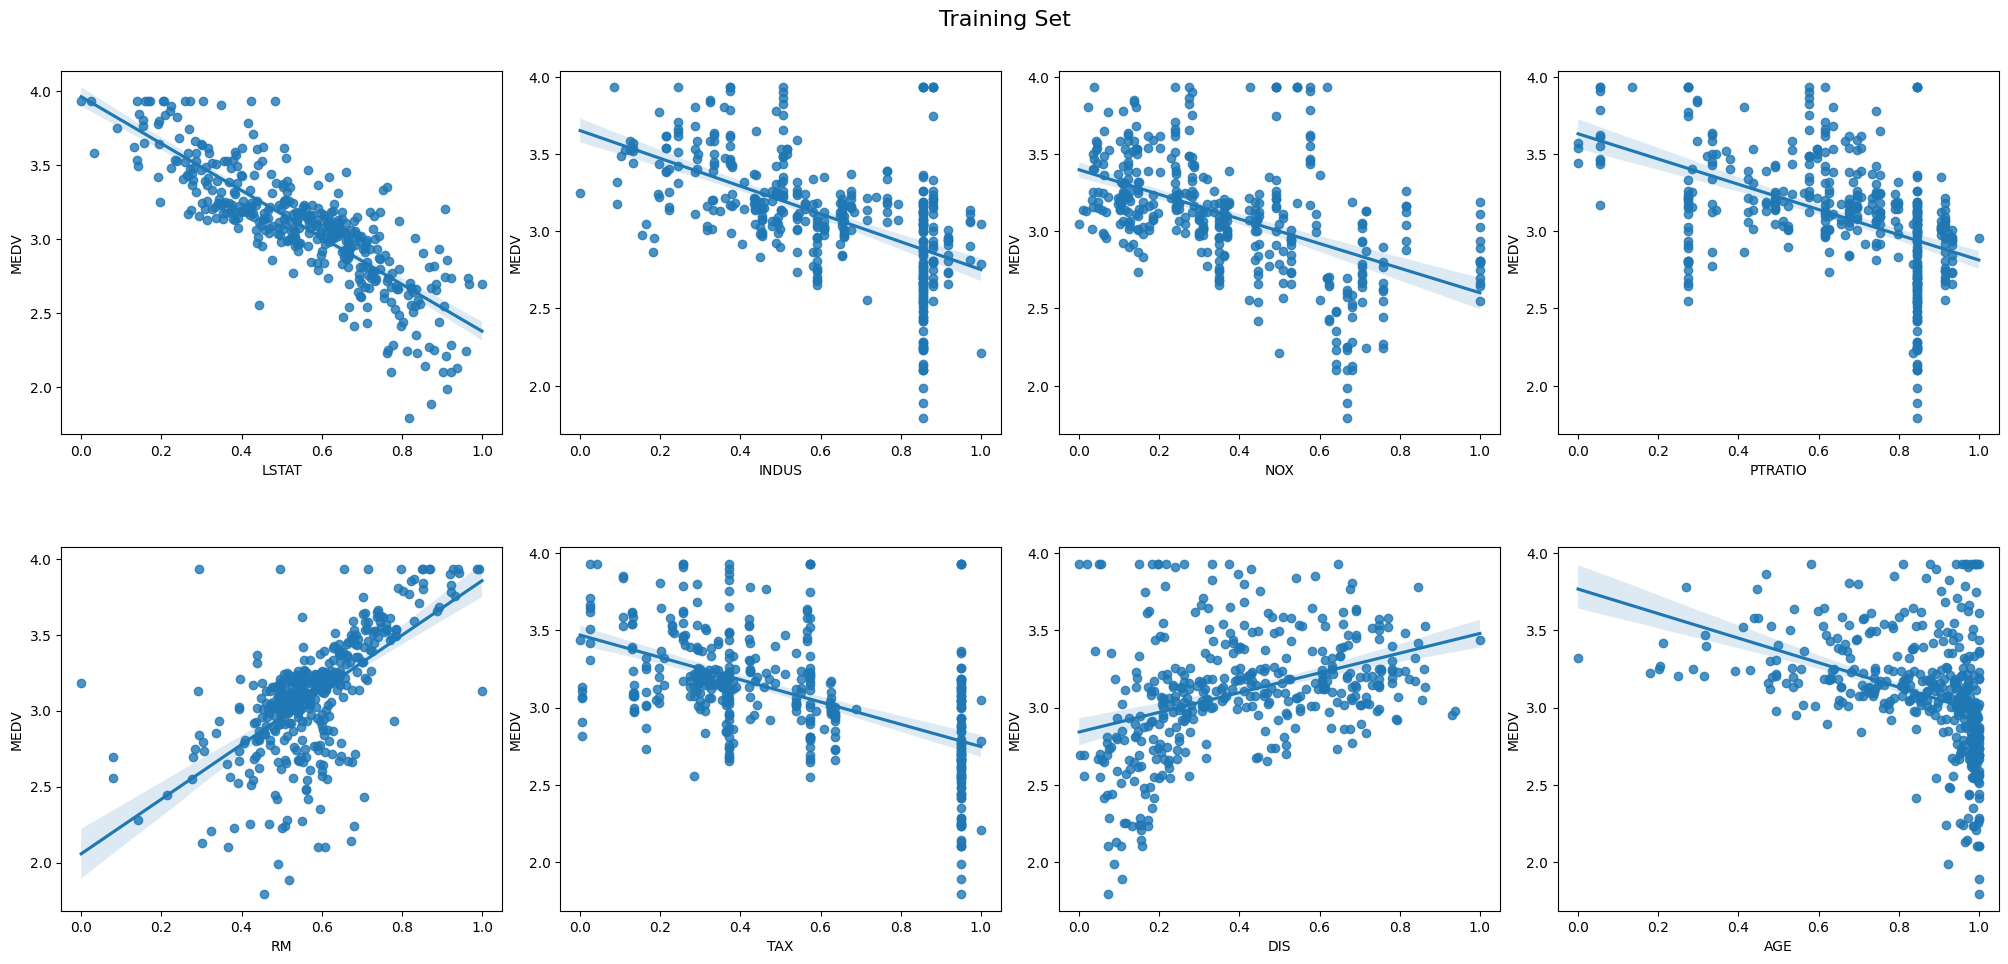

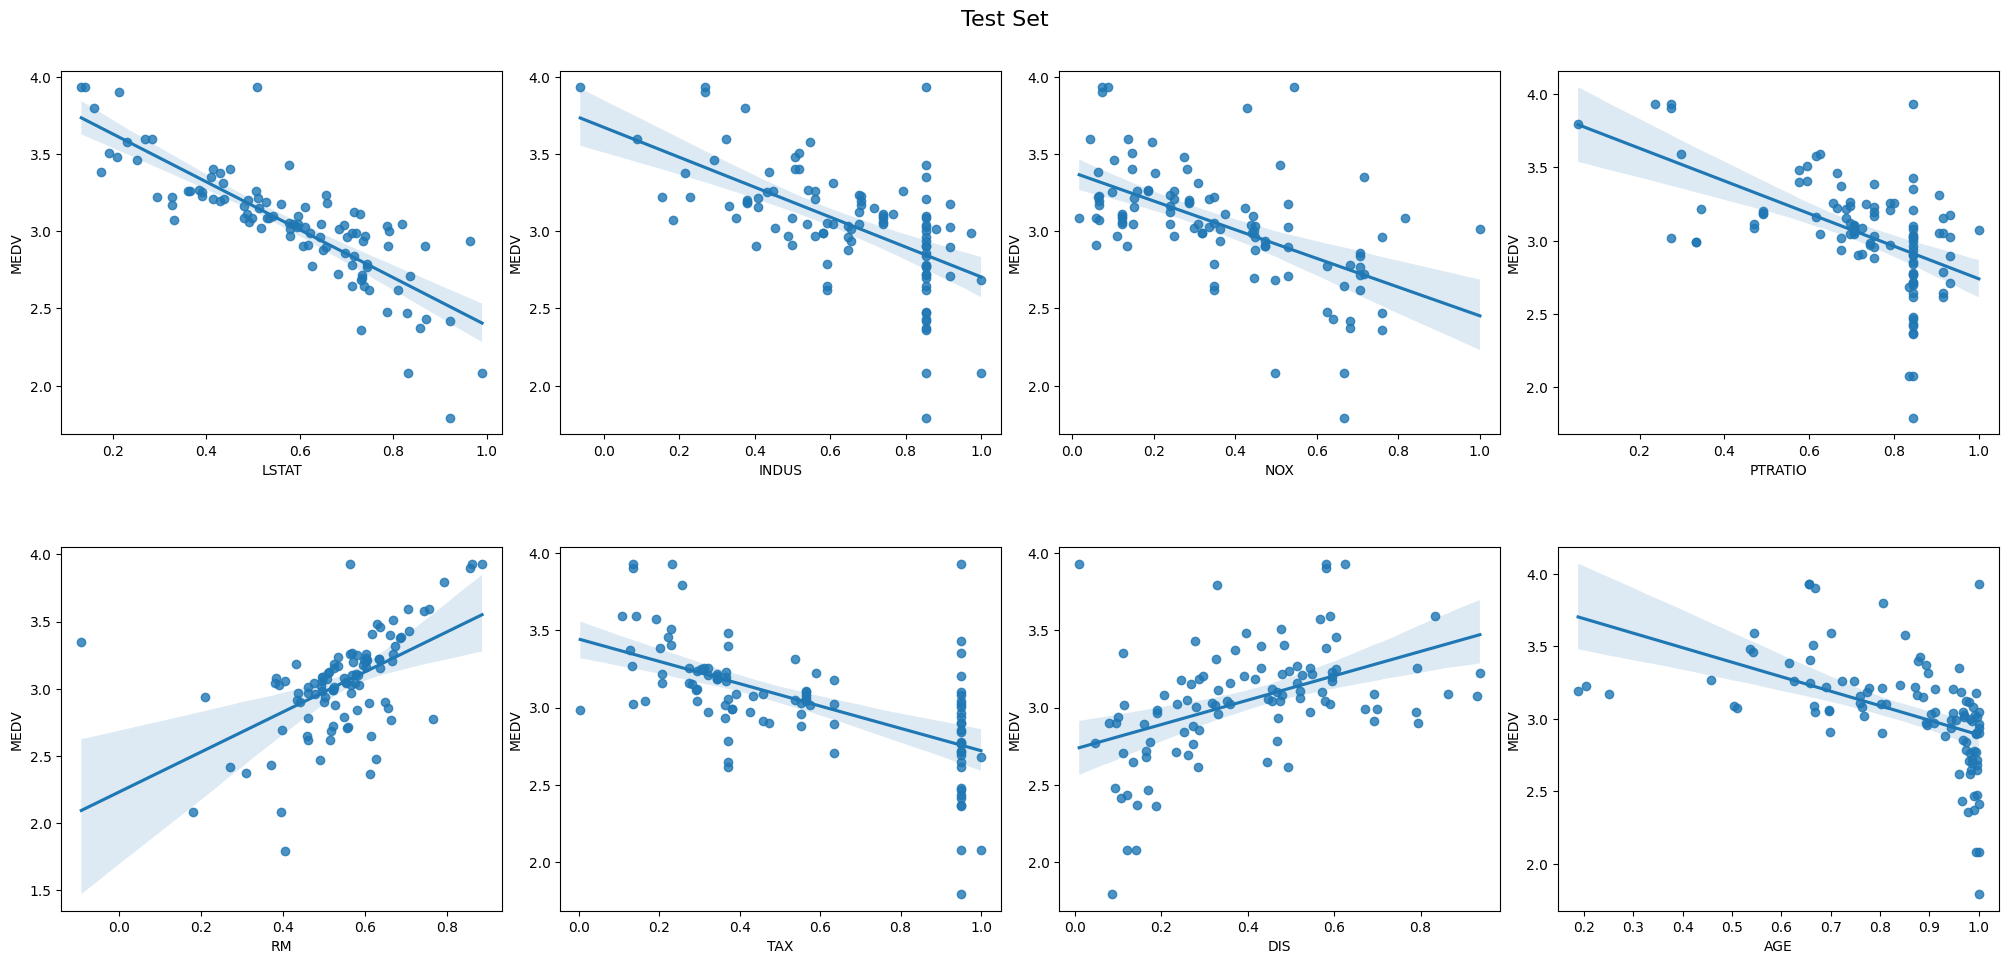

In [12]:
def preprocessing(x_train, x_test, y_train, y_test):
    # Apply log transformation to the target variable
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # Check skewness and apply log transformation if necessary
    for col in x_train.columns:
        if np.abs(x_train[col].skew()) > 0.3:
            x_train[col] = np.log1p(x_train[col])
            x_test[col] = np.log1p(x_test[col])

    # Fit the scaler on the training data and transform both train and test data
    min_max_scaler = MinMaxScaler()
    x_train_scaled = pd.DataFrame(data=min_max_scaler.fit_transform(x_train), columns=x_train.columns)
    x_test_scaled = pd.DataFrame(data=min_max_scaler.transform(x_test), columns=x_test.columns)

    return x_train_scaled, x_test_scaled, y_train, y_test

def read_dataframe(filename="data/housing.csv"):

    df = pd.read_csv(filename, header=None, delimiter=r"\s+", names=column_names)
    # Load the dataset
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    # Split the dataset into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42) 
    # Separate features and target for train and test sets
    x_train = train_df.loc[:, ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']]
    y_train = train_df['MEDV']
    x_test = test_df.loc[:, ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']]
    y_test = test_df['MEDV']
    # Apply preprocessing
    x_train_scaled, x_test_scaled, y_train, y_test = preprocessing(x_train, x_test, y_train, y_test)
    return x_train_scaled, x_test_scaled, y_train, y_test


So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features. Let's try to remove the skewness of the data trough log transformation.

Let's try Linear, Ridge Regression on dataset first.

In [3]:


# Define a custom transformer for applying log transformation
class LogTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(func=np.log1p, validate=False)
    
    def inverse_transform(self, X):
        return np.expm1(X)

def load_data(url="https://raw.githubusercontent.com/arunv22/zoomcamp_mlops_project/main/data/housing.csv"):
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    df = pd.read_csv(url, header=None, delimiter=r"\s+", names=column_names)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    x_train = train_df.loc[:, ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']]
    y_train = train_df['MEDV']
    x_test = test_df.loc[:, ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']]
    y_test = test_df['MEDV']
    
    return x_train, x_test, y_train, y_test

def create_pipeline(model):
    return Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('log', LogTransformer(), ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']),
                ('scaler', MinMaxScaler(), ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE'])
            ],
            remainder='passthrough'
        )),
        ('model', model)
    ])

def train_and_log_models(x_train, y_train, x_test, y_test):
    mlflow.set_experiment("boston-housing-experiment")
    
    models = {
        'Linear Regression': linear_model.LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Ridge Regression': linear_model.Ridge(alpha=0.1),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    }
    
    for name, model in models.items():
        with mlflow.start_run() as run:
            mlflow.set_tag("developer", "arun")
            mlflow.log_param("train-data-path", "./data/housing.csv")
            
            if name == 'XGBoost':
                model.fit(x_train, np.log1p(y_train))
                y_pred_log = model.predict(x_test)
            else:
                pipeline = create_pipeline(model)
                pipeline.fit(x_train, np.log1p(y_train))
                y_pred_log = pipeline.predict(x_test)
                
            y_pred = np.expm1(y_pred_log)
            y_test_original = np.expm1(np.log1p(y_test))
            
            mse = mean_squared_error(y_test_original, y_pred)
            mlflow.log_metric("mse", mse)
            
            # Log the model using mlflow.sklearn or mlflow.xgboost
            model_name = name.replace(' ', '_')
            if name == 'XGBoost':
                mlflow.xgboost.log_model(model, artifact_path=f"models/{model_name}")
            else:
                mlflow.sklearn.log_model(pipeline, artifact_path=f"models/{model_name}")
            
            print(f"{name} logged with MSE: {mse:.2f}")
            print(f"Model artifact path: runs:/{run.info.run_id}/models/{model_name}")

def get_best_run_uri(experiment_name, metric_name, metric_goal='minimize'):
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError("Experiment not found.")
    
    # Search for runs in the experiment
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string='',
        order_by=[f"metrics.{metric_name} {'asc' if metric_goal == 'minimize' else 'desc'}"]
    )

    if not runs.empty:
        best_run = runs.iloc[0]
        best_run_id = best_run.run_id
        best_artifact_path = json.loads(best_run["tags.mlflow.log-model.history"])[0]["artifact_path"]
        logged_model_uri = f"runs:/{best_run_id}/{best_artifact_path}"
        return best_run_id, logged_model_uri
    else:
        raise ValueError("No runs found for the specified experiment.")

def test_model(logged_model_uri, x_test, y_test):
    try:
        # Load model
        loaded_model = mlflow.pyfunc.load_model(logged_model_uri)
        
        # Predict on test data
        y_pred = loaded_model.predict(pd.DataFrame(x_test))
        
        # Calculate RMSE on original scale
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE on original scale: {rmse:.2f}")
        
        return {"rmse": rmse}
    except Exception as e:
        print(f"Error loading model from {logged_model_uri}: {e}")

# Load data
x_train, x_test, y_train, y_test = load_data()

# Train and log models
train_and_log_models(x_train, y_train, x_test, y_test)

# Fetch the best model URI and test
experiment_name = "boston-housing-experiment"
metric_name = "mse"
run_id, logged_model_uri = get_best_run_uri(experiment_name, metric_name)

print(f"Best Model Run ID: {run_id}")
print(f"Best Model URI: {logged_model_uri}")

# Test the best model
results = test_model(logged_model_uri, x_test, y_test)
print(results)


Linear Regression logged with MSE: 16.80
Model artifact path: runs:/562ea279b5fb4c63a385844aa67579c2/models/Linear_Regression


C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Random Forest logged with MSE: 9.00
Model artifact path: runs:/011c09fb39a74040a36826b99108e245/models/Random_Forest


C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Ridge Regression logged with MSE: 18.05
Model artifact path: runs:/0c99c540d99a4829b12c9213a8e15156/models/Ridge_Regression


C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\arunv\zoomcamp_mlops_project\venv\lib\site-packages\_distu

XGBoost logged with MSE: 12.50
Model artifact path: runs:/18511d533ff64019b3405fb19a7c9d6a/models/XGBoost
Best Model Run ID: 011c09fb39a74040a36826b99108e245
Best Model URI: runs:/011c09fb39a74040a36826b99108e245/models/Random_Forest
RMSE on original scale: 20.21
{'rmse': 20.211159418062714}


In [76]:

client.transition_model_version_stage(
    name = 'boston_housing_xgboost',
    version = 2,
    stage='Production',
    archive_existing_versions=True
)
    

C:\Users\arunv\AppData\Local\Temp\ipykernel_15128\406917444.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1720605968257, current_stage='Production', description='', last_updated_timestamp=1720610422305, name='boston_housing_xgboost', run_id='3732dd5781ce4d129b4a4436be05de19', run_link='', source='file:///C:/Projects/zoomcamp_mlops_project/mlruns/1/3732dd5781ce4d129b4a4436be05de19/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [73]:
import mlflow
from mlflow.tracking import MlflowClient

# Initialize the MLflow client
client = MlflowClient()

# List all registered models using search_registered_models
models = client.search_registered_models()

# Print the registered models and their versions
for model in models:
    print(f"Model Name: {model.name}")
    for version in model.latest_versions:
        print(f"  Version: {version.version}, Stage: {version.current_stage}")


Model Name: boston_housing_xgboost
  Version: 1, Stage: None
  Version: 2, Stage: Staging


In [52]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri = MLFLOW_TRACKING_URI)


In [55]:
# List all experiments
experiments = mlflow.search_experiments()

# Print out the experiments
for experiment in experiments:
    print(f"Experiment ID: {experiment.experiment_id}, Name: {experiment.name}")

Experiment ID: 1, Name: boston-housing-experiment
Experiment ID: 0, Name: Default


In [57]:
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

# Initialize the MLflow client
client = MlflowClient()

# Define the experiment ID
experiment_id = '1'

# Search runs
runs = client.search_runs(
    experiment_ids=[experiment_id],  # Note: experiment_ids should be a list
    filter_string="",  # No filter, get all runs
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]  # Note: order_by should be a list
)

# Print the runs with their RMSE values
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")


run id: 3732dd5781ce4d129b4a4436be05de19, rmse: 0.1418
run id: 09f6c45d866b407bbb6366c1f8cb8e6b, rmse: 0.1418
run id: 97e5571844f049bab075d1e56f608077, rmse: 0.1420
run id: 5fed15474eee4284b23c13ab32e488d0, rmse: 0.1464
run id: 4c15b8f78d1c4f058e7e490b33515851, rmse: 0.1489
